In [69]:
import math
import numpy as np
import pandas as pd
import pandas_datareader as pdd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential 
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [70]:
df = pdd.DataReader('AAPL', data_source='yahoo', start='2002-02-01', end='2017-01-31')
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2002-02-01,0.445714,0.434643,0.434643,0.435893,398305600.0,0.375462
2002-02-04,0.455714,0.432143,0.434286,0.452679,522373600.0,0.389921
2002-02-05,0.463929,0.447857,0.448036,0.454464,456887200.0,0.391459
2002-02-06,0.463929,0.431250,0.457143,0.440536,597576000.0,0.379462
2002-02-07,0.451607,0.430000,0.440179,0.433929,347832800.0,0.373771
...,...,...,...,...,...,...
2017-01-25,30.525000,30.070000,30.105000,30.469999,129510400.0,28.814610
2017-01-26,30.610001,30.400000,30.417500,30.485001,105350400.0,28.828796
2017-01-27,30.587500,30.400000,30.535000,30.487499,82251600.0,28.831160


<function matplotlib.pyplot.show>

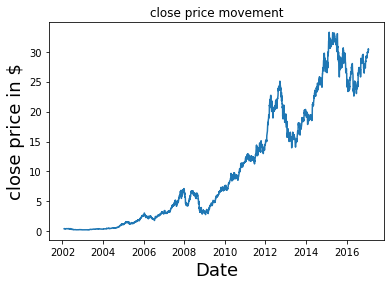

In [71]:
 
plt.figure()
plt.title('close price movement')
plt.plot(df['Close'])
plt.xlabel('Date', fontsize=18)
plt.ylabel('close price in $', fontsize=18)
plt.show

In [72]:
data = df.filter(['Close'])
dataset = data.values
len(dataset)

3776

In [73]:
#split the data to 80/20
training_data_size = math.ceil(len(dataset)*.8)
training_data_size

3021

In [74]:
#data normalization to rescale the data to between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)
scaled_data

array([[0.0061064 ],
       [0.00661482],
       [0.00666888],
       ...,
       [0.9163277 ],
       [0.91390461],
       [0.91178442]])

In [75]:
#input of lstm, step = 60
train_data = scaled_data[0:training_data_size, :]
x_train=[]
y_train=[]
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i,0])
  if i<=60:
    print(x_train)
    print(y_train)


[array([0.0061064 , 0.00661482, 0.00666888, 0.00624703, 0.00604691,
       0.00590086, 0.00641467, 0.00626865, 0.00643091, 0.00620916,
       0.00583056, 0.00513825, 0.00541409, 0.00453248, 0.00520313,
       0.00578188, 0.00570616, 0.00478127, 0.00464064, 0.00558716,
       0.00604149, 0.00563044, 0.00592248, 0.00609016, 0.0062416 ,
       0.00645795, 0.00627407, 0.00614965, 0.00611721, 0.00639847,
       0.00628489, 0.00634437, 0.00638223, 0.00603067, 0.00593333,
       0.00553306, 0.00559258, 0.00559797, 0.00570616, 0.00613344,
       0.00592248, 0.00574941, 0.00637142, 0.00628489, 0.00618751,
       0.00593872, 0.0062416 , 0.00634979, 0.00645795, 0.00642552,
       0.00682575, 0.00702587, 0.00664726, 0.00641467, 0.0061713 ,
       0.00601986, 0.00576023, 0.00594953, 0.00534918, 0.005863  ])]
[0.006030673944057374]


In [76]:
x_train, Y_train = np.array(x_train), np.array(y_train)
#convert the data into 3D for lstm input
x_train=np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_train.shape

(2961, 60, 1)

In [77]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))


In [78]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, Y_train, batch_size=1, epochs=1)

2961/2961 [==============================] - 70s 23ms/step - loss: 0.0025


In [79]:
test_data = scaled_data[training_data_size - 60:, :]
x_test = []
y_test = dataset[training_data_size:, :]
for i in range(60, len(test_data)):
  #print(i)
  x_test.append(test_data[i-60:i, 0])
  

In [80]:
x_test =np.array(x_test)

In [81]:
x_test=np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

In [82]:
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [83]:
rmse = np.sqrt(np.mean(predictions-y_test)**2)
rmse

0.21604244409018006

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


<function matplotlib.pyplot.show>

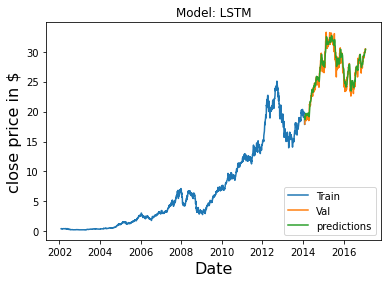

In [84]:
train=data[:training_data_size]
valid=data[training_data_size:]
valid['predictions']=predictions
plt.figure()
plt.title('Model: LSTM')
plt.xlabel('Date', fontsize=16)
plt.ylabel('close price in $', fontsize=16)
plt.plot(train['Close'])
plt.plot(valid[['Close', 'predictions']])
plt.legend(['Train','Val', 'predictions'], loc='lower right')
plt.show